# Build a Traffic Sign Recognition Classifier Deep Learning

Some improvements are taken :
- [x] Adding of convolution networks at the same size of previous layer, to get 1x1 layer
- [x] Activation function use 'ReLU' instead of 'tanh'
- [x] Adaptative learning rate, so learning rate is decayed along to training phase

## Load and Visualize the German Traffic Signs Dataset.

In [1]:
# Load pickled data
import pickle
import numpy

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
X_valid, y_valid = valid['features'], valid['labels'] # validation dataset used in training phase
X_test, y_test   = test['features'], test['labels']   # test dataset
n_classes        = len(numpy.unique(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape    : {}".format(X_train[0].shape))
print()
print("Training Set   : {} samples".format(len(X_train)))
print("Validation Set : {} samples".format(len(X_valid)))
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))


Image Shape    : (32, 32, 3)

Training Set   : 34799 samples
Validation Set : 4410 samples
Test Set       : 12630 samples
n_classes      : 43


## Implementation of LeNet

>http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf  
Above is the original article of Pierre Sermanet and Yann LeCun in 1998 that we can follow to create LeNet convolutional networks with a good accuracy even for very-beginners in deep-learning.  
It's really excited to see that many years of works now could be implemented in just 9 lines of code thank to Keras high-level API !
(low-level API implementation with Tensorflow 1 is roughly 20 lines of code)  

>Here is also an interesting medium article :  
https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086  

In [2]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


### 2-stage ConvNet architecture by Pierre Sermanet and Yann LeCun

We will try to implement the 2-stage ConvNet architecture by Pierre Sermanet and Yann LeCun which is not sequential. 

Keras disposes keras.Sequential() API for sequential architectures but it can not handle models with non-linear topology, shared layers or multi-in/output. So the choose of the 2-stage ConvNet architecture by `Pierre Sermanet` and `Yann LeCun` is to challenge us also.

<img src="figures/lenet_2.png" alt="Drawing" style="width: 550px;"/>

>Source: "Traffic Sign Recognition with Multi-Scale Convolutional Networks" by `Pierre Sermanet` and `Yann LeCun`

Here in this architecture, the 1st stage's ouput is feed-forward to the classifier (could be considered as a 3rd stage).

In [3]:
#LeNet model
inputs           = keras.Input(shape=(32,32,1), name='image_in')

#1st stage ___________________________________________________________
#Convolution with ReLU activation
layer1_conv      = keras.layers.Conv2D(32, kernel_size=(5,5), strides=1, activation='relu', padding='valid')(inputs)
#Average Pooling
layer1_maxpool   = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(layer1_conv)
#Conv 1x1
layer1_conv1x1   = keras.layers.Conv2D(256, kernel_size=(14,14), strides=1, activation='relu', padding='valid')(layer1_maxpool)

#2nd stage ___________________________________________________________
#Convolution with ReLU activation
layer2_conv      = keras.layers.Conv2D(64, kernel_size=(5,5), strides=1, activation='relu', padding='valid')(layer1_maxpool)
#MaxPooling 2D
layer2_maxpool   = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(layer2_conv)
#Conv 1x1
layer2_conv1x1   = keras.layers.Conv2D(512, kernel_size=(5,5), strides=1, activation='relu', padding='valid')(layer2_maxpool)

#3rd stage | Classifier ______________________________________________
#Concate
layer3_flatten_1 = keras.layers.Flatten()(layer1_conv1x1)
layer3_flatten_2 = keras.layers.Flatten()(layer2_conv1x1)
layer3_concat    = keras.layers.Concatenate()([layer3_flatten_1, layer3_flatten_2])

#Dense (fully-connected)
layer3_dense_1     = keras.layers.Dense(units=129, activation='relu', kernel_initializer="he_normal")(layer3_concat)
# layer3_dense_2     = keras.layers.Dense(units=129, activation='relu', kernel_initializer="he_normal")(layer3_dense_1)
#Dense (fully-connected) | logits for 43 categories (n_classes)
outputs            = keras.layers.Dense(units=n_classes)(layer3_dense_1)

LeNet_Model        = keras.Model(inputs, outputs, name="LeNet_Model_improved")

Model: "LeNet_Model_improved"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   832         image_in[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 64)   51264       max_pooling2d[0][0]              
_______________________________________________________________________________

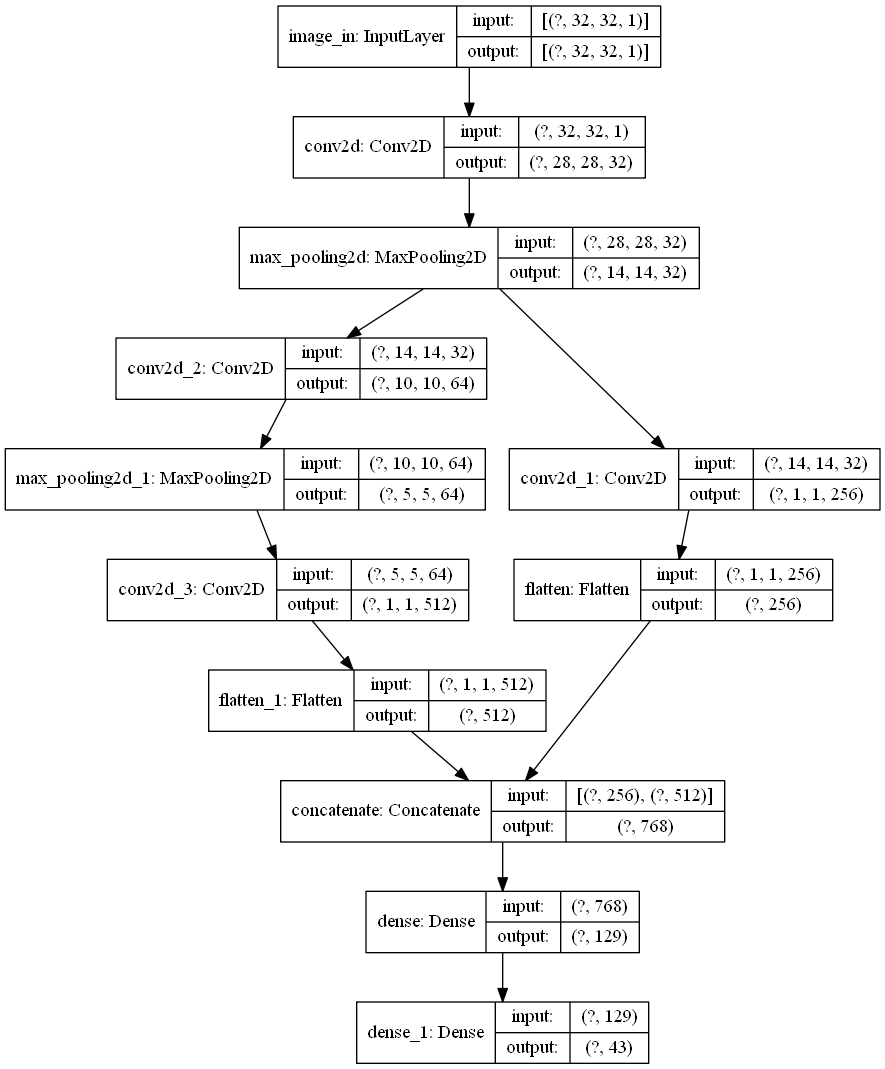

In [4]:
#Plot model architecture
LeNet_Model.summary()
keras.utils.plot_model(LeNet_Model, "figures/LeNet_improved.png", show_shapes=True)

### Input preprocessing

#### Color-Space
Pierre Sermanet and Yann LeCun used YUV color space with almost of processings on Y-channel (Y stands for brightness, U and V stand for Chrominance).  

#### Normalization
Each channel of an image is in uint8 scale (0-255), we will normalize each channel to 0-1.  
Generally, we normalize data to get them center around -1 and 1, to prevent numrical errors due to many steps of matrix operation. Imagine that we have 255x255x255x255xk operation, it could give a huge numerical error if we just have a small error in k.  

In [4]:
import cv2
def input_normalization(X_in):    
    X       = numpy.array([numpy.expand_dims(cv2.cvtColor(image_ij, cv2.COLOR_RGB2YUV)[:,:,0],2) for image_ij in X_in])
    X       = numpy.array([numpy.expand_dims(cv2.equalizeHist(numpy.uint8(image_ij)),2) for image_ij in X])
    X       = numpy.float32(X/255.0)
    #X       = (X-128)/128.0
    # nomalize features
    X -= numpy.mean(X, axis=0)
    X /= (numpy.std(X, axis=0) + numpy.finfo('float32').eps)
    return X

In [6]:
# normalization of dataset
X_train_norm     = input_normalization(X_train)
X_valid_norm     = input_normalization(X_valid)

# one-hot matrix
y_train_onehot   = keras.utils.to_categorical(y_train, n_classes)
y_valid_onehot   = keras.utils.to_categorical(y_valid, n_classes)

In [7]:
print(X_train_norm.shape)
print('{0:.4g}'.format(numpy.max(X_train_norm)))
print('{0:.3g}'.format(numpy.min(X_train_norm)))

(34799, 32, 32, 1)
2.264
-2.78


### Training Pipeline
_Optimizer : we use Adam optimizer, better than SDG (Stochastic Gradient Descent)  
_Loss function : Cross Entropy by category  
_Metrics : accuracy  
*learning rate 0.001 work well with our network, it's better to try with small laerning rate in the begining.

In [8]:
rate = 0.001

LeNet_Model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate = rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

### Real-time data augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rotation_range=15.0,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            horizontal_flip=False)

datagen.fit(X_train_norm)

### Train the Model


In [10]:
EPOCHS          = 30
BATCH_SIZE      = 32
STEPS_PER_EPOCH = int(len(X_train_norm)/BATCH_SIZE)

history         = LeNet_Model.fit(
                datagen.flow(X_train_norm, y_train_onehot, batch_size=BATCH_SIZE,shuffle=True),
                validation_data=(X_valid_norm, y_valid_onehot),
                shuffle=True,
                steps_per_epoch=STEPS_PER_EPOCH,
                epochs=EPOCHS)

LeNet_Model.save("LeNet_improved.h5")

  ...
    to  
  ['...']
Train for 1087 steps, validate on 4410 samples
Epoch 1/30
1087/1087 [==============================] - 67s 61ms/step - loss: 1.0683 - accuracy: 0.6825 - val_loss: 0.3380 - val_accuracy: 0.8966
Epoch 2/30
1087/1087 [==============================] - 66s 60ms/step - loss: 0.3164 - accuracy: 0.8988 - val_loss: 0.3830 - val_accuracy: 0.8896
Epoch 3/30
1087/1087 [==============================] - 63s 58ms/step - loss: 0.2018 - accuracy: 0.9353 - val_loss: 0.2028 - val_accuracy: 0.9401
Epoch 4/30
1087/1087 [==============================] - 66s 61ms/step - loss: 0.1650 - accuracy: 0.9477 - val_loss: 0.1658 - val_accuracy: 0.9537
Epoch 5/30
1087/1087 [==============================] - 63s 58ms/step - loss: 0.1322 - accuracy: 0.9579 - val_loss: 0.1655 - val_accuracy: 0.9522
Epoch 6/30
1087/1087 [==============================] - 68s 62ms/step - loss: 0.1251 - accuracy: 0.9595 - val_loss: 0.2004 - val_accuracy: 0.9460
Epoch 7/30
1087/1087 [==============================

### Evaluate the Model
We will use the test dataset to evaluate classification accuracy.

In [11]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [12]:
#Load saved model
reconstructed_LeNet_Model = keras.models.load_model("LeNet_improved.h5")

#Evaluate and display the prediction
result                    = reconstructed_LeNet_Model.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed_LeNet_Model.metrics_names, result))

12630/12630 [==============================] - 6s 472us/sample - loss: 0.2170 - accuracy: 0.9547


{'loss': 0.2170438812019665, 'accuracy': 0.954711}

In [13]:
pickle.dump(history.history, open( "history_LeNet_improved.p", "wb" ))

In [14]:
with open("history_LeNet_improved.p", mode='rb') as f:
    history_ = pickle.load(f)


Plot of training error over 30 epochs:


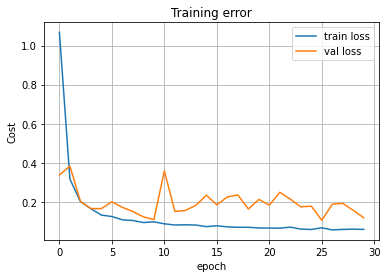

In [15]:
import matplotlib.pyplot as plt

# Plot training error.
print('\nPlot of training error over 30 epochs:')
fig = plt.figure()
plt.title('Training error')
plt.ylabel('Cost')
plt.xlabel('epoch')
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.grid()
plt.show()
fig.savefig('figures/Training_loss_LeNet_improved.png', dpi=500)


Plot of training accuracy over 30 epochs:


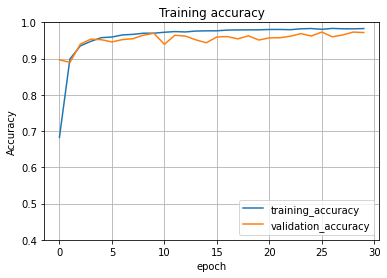

In [16]:
# Plot training error.
print('\nPlot of training accuracy over 30 epochs:')
fig = plt.figure()
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.xlabel('epoch')
plt.plot(history_['accuracy'])
plt.plot(history_['val_accuracy'])
plt.legend(['training_accuracy', 'validation_accuracy'], loc='lower right')
plt.grid()
plt.show()
fig.savefig('figures/Training_accuracy_LeNet_improved.png', dpi=500)

### Prediction of test dataset with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.

In [17]:
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
X_test.shape

Test Set       : 12630 samples
n_classes      : 43


(12630, 32, 32, 3)

In [18]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [19]:
#Load saved model
reconstructed = keras.models.load_model("LeNet_improved.h5")

#Evaluate and display the prediction
prediction_performance    = reconstructed.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

12630/12630 [==============================] - 6s 483us/sample - loss: 0.2170 - accuracy: 0.9547


{'loss': 0.2170438812019665, 'accuracy': 0.954711}

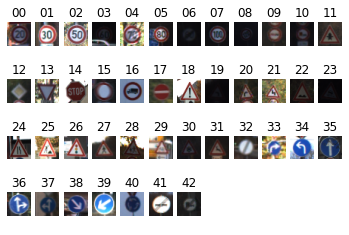

In [20]:
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        #X_train_0       = X_train_of_class[numpy.random.randint(len(X_train_of_class))]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        ax.axis('off')
        ax.set_title('{:02d}'.format(idx))
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plot.draw()
fig.savefig('figures/' + 'test_representative' + '.jpg', dpi=700)

In [21]:
#### Prediction for all instances inside the test dataset
y_pred_proba   = reconstructed.predict(X_test_norm)
y_pred_class   = y_pred_proba.argmax(axis=-1)

### Showing prediction results for 10 first instances
for i, pred in enumerate(y_pred_class):
    if i <= 10:        
        print('Image {} - Target = {}, Predicted = {}'.format(i, y_test[i], pred))
    else:
        break

Image 0 - Target = 16, Predicted = 16
Image 1 - Target = 1, Predicted = 1
Image 2 - Target = 38, Predicted = 38
Image 3 - Target = 33, Predicted = 33
Image 4 - Target = 11, Predicted = 11
Image 5 - Target = 38, Predicted = 38
Image 6 - Target = 18, Predicted = 18
Image 7 - Target = 12, Predicted = 12
Image 8 - Target = 25, Predicted = 25
Image 9 - Target = 35, Predicted = 35
Image 10 - Target = 12, Predicted = 12


We will display a confusion matrix on test dataset to figure out our error-rate.  
`X_test_norm`    : test dataset  
`y_test`         : test dataset ground truth labels  
`y_pred_class`   : prediction labels on test dataset  

In [22]:
confusion_matrix = numpy.zeros([n_classes, n_classes])

#### confusion_matrix
`column`      : test dataset ground truth labels  
`row`         : prediction labels on test dataset  
`diagonal`    : incremented when prediction matches ground truth label  

In [23]:
for ij in range(len(X_test_norm)):
    if y_test[ij] == y_pred_class[ij]:
        confusion_matrix[y_test[ij],y_test[ij]] += 1
    else:
        confusion_matrix[y_pred_class[ij],y_test[ij]] -= 1

In [24]:
column_label = ['     L % d' % x for x in range(n_classes)]
row_label    = ['     P % d' % x for x in range(n_classes)]

In [25]:
# Plot classe representatives
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 1, 43
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
        # plot.tick_params(axis='both', which='both', bottom='off', top='off',
        # labelbottom='off', right='off', left='off', labelleft='off')
        ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'label_groundtruth' + '.jpg', dpi=3500)

In [26]:
numpy.savetxt("confusion_matrix_LeNet_improved.csv", confusion_matrix, delimiter=";")

#### Thank to confusion matrix, we could identify where to enhance  
-[x] training dataset  
-[x] real-time data augmentation  
-[x] preprocessing  

*Extract of confusion matrix of classification on test dataset &#8595;*  
<img src="figures/confusion_matrix_LeNet.png" alt="Drawing" style="width: 750px;"/>

### Prediction of new instances with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.
I didn't 'softmax' activation in the last layer of LeNet architecture, so the output prediction is logits. To have prediction confidence level, we can apply softmax function to output logits.

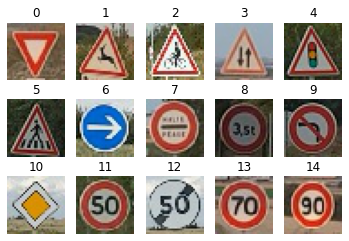

In [6]:
# load french traffic signs
import os
import cv2
import matplotlib.pyplot as plot
import numpy
dir_frenchsign     = 'french_traffic-signs-data'
images_frenchsign  = [os.path.join(dir_frenchsign, f) for f in os.listdir(dir_frenchsign)]
images_frenchsign  = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in images_frenchsign]

# plot new test images
fig, axes          = plot.subplots(3, int(len(images_frenchsign)/3))
plot.title('French traffic signs')
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images_frenchsign[i])
    ax.set_title('{}'.format(i))
    plot.setp(ax.get_xticklabels(), visible=False)
    plot.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'french_sign' + '.jpg', dpi=700)

*German traffic signs from INI dataset, in stardard form &#8595;*  
<img src="figures/german_sign.jpg" alt="Drawing" style="width: 600px;"/>

In [7]:
# manually label for these new images
y_frenchsign       = [13, 31, 29, 24, 26, 27, 33, 17, 15, 34, 12, 2, 2, 4, 2]
n_classes          = 43

# when a sign doesn't present in our training dataset, we'll try to find a enough 'similar' sign to label it.

# image 2 : class 29 differed 
# image 3 : class 24, double-sens not existed 
# image 5 : class 27 differed
# image 6 : class 33 not existed 
# image 7 : class 17, halte-péage not existed 
# image 8 : class 15, 3.5t limit not existed 
# image 9 : class 15, turn-left inhibition not existed
# image 12 : class 2, ending of 50kmh speed-limit not existed
# image 14 : class 2, 90kmh speed-limit not existed

#### it's really intersting that somes common french traffic signs are not present in INI German traffic signs dataset or differed
Whatever our input - evenif it's not present in the training dataset, by using softmax activation our classififer can not say that 'this is a new traffic sign that it doesn't recognize' (sum of probability across all classes is 1), it's just try to find class that probably suit for the input.

In [9]:
#Normalize the dataset
X_frenchsign_norm        = input_normalization(images_frenchsign)
#One-hot matrix
y_frenchsign_onehot      = keras.utils.to_categorical(y_frenchsign, n_classes)

#Load saved model
reconstructed            = keras.models.load_model("LeNet_improved.h5")

#Evaluate and display the prediction performance
prediction_performance   = reconstructed.evaluate(X_frenchsign_norm, y_frenchsign_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

15/15 [==============================] - 0s 20ms/sample - loss: 5.5353 - accuracy: 0.4000


{'loss': 5.535292625427246, 'accuracy': 0.4}

In [10]:
#### Prediction for all instances inside the test dataset
y_pred_logits            = reconstructed.predict(X_frenchsign_norm)
y_pred_proba             = tf.nn.softmax(y_pred_logits).numpy()
y_pred_class             = y_pred_proba.argmax(axis=-1)

### Showing prediction results
for i, pred in enumerate(y_pred_class):   
    print('Image {} - Target = {}, Predicted = {}'.format(i, y_frenchsign[i], pred))

Image 0 - Target = 13, Predicted = 13
Image 1 - Target = 31, Predicted = 31
Image 2 - Target = 29, Predicted = 28
Image 3 - Target = 24, Predicted = 24
Image 4 - Target = 26, Predicted = 10
Image 5 - Target = 27, Predicted = 38
Image 6 - Target = 33, Predicted = 38
Image 7 - Target = 17, Predicted = 12
Image 8 - Target = 15, Predicted = 5
Image 9 - Target = 34, Predicted = 38
Image 10 - Target = 12, Predicted = 12
Image 11 - Target = 2, Predicted = 2
Image 12 - Target = 2, Predicted = 32
Image 13 - Target = 4, Predicted = 4
Image 14 - Target = 2, Predicted = 5


*French traffic signs to classsify &#8595;*  
<img src="figures/french_sign_compare_german_INI.jpg" alt="Drawing" style="width: 750px;"/>

Top 3 model predictions for image 0 (Target is 13)
   Prediction = 15 with probability 0.0000 (logit is 2.6677)
   Prediction = 14 with probability 0.0000 (logit is 7.9109)
   Prediction = 13 with probability 1.0000 (logit is 22.3143)
Top 3 model predictions for image 1 (Target is 31)
   Prediction = 23 with probability 0.0002 (logit is 3.7116)
   Prediction = 19 with probability 0.0013 (logit is 5.5671)
   Prediction = 31 with probability 0.9984 (logit is 12.2443)
Top 3 model predictions for image 2 (Target is 29)
   Prediction = 27 with probability 0.0215 (logit is 6.2642)
   Prediction = 24 with probability 0.0738 (logit is 7.4961)
   Prediction = 28 with probability 0.9015 (logit is 9.9981)
Top 3 model predictions for image 3 (Target is 24)
   Prediction = 18 with probability 0.0000 (logit is 5.3769)
   Prediction = 30 with probability 0.0000 (logit is 6.0360)
   Prediction = 24 with probability 1.0000 (logit is 16.6244)
Top 3 model predictions for image 4 (Target is 26)
   Predict

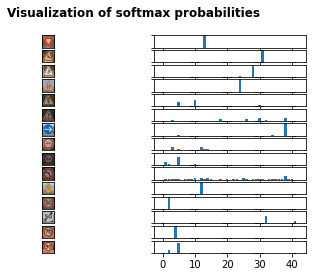

In [11]:
#### plot softmax probs along with traffic sign examples
n_img        = X_frenchsign_norm.shape[0]
fig, axarray = plot.subplots(n_img, 2)
plot.suptitle('Visualization of softmax probabilities', fontweight='bold')
for r in range(0, n_img):
    axarray[r, 0].imshow(numpy.squeeze(images_frenchsign[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plot.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plot.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(numpy.arange(n_classes), y_pred_proba[r])
    axarray[r, 1].set_ylim([0, 1])
    plot.setp(axarray[r, 1].get_yticklabels(), visible=False)
plot.draw()
fig.savefig('figures/' + 'french_sign_softmax_visuali_LeNet_improved' + '.jpg', dpi=700)
    
K = 3
#### print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(images_frenchsign)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, y_frenchsign[i]))
    top_3_idx    = numpy.argsort(y_pred_proba[i])[-3:]
    top_3_values = y_pred_proba[i][top_3_idx]    
    top_3_logits = y_pred_logits[i][top_3_idx]    
    for k in range(K):
        print('   Prediction = {:02d} with probability {:.4f} (logit is {:.4f})'.format(top_3_idx[k], top_3_values[k], top_3_logits[k]))

*Visualization of softmax probabilities &#8595;*  
<img src="figures/french_sign_softmax_visuali_LeNet_improved.jpg" alt="Drawing" style="width: 750px;"/>

## Visualization of layers

In [12]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
import matplotlib.pyplot as plot

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [13]:
# Load pickled data
import pickle
import numpy

training_file    = 'traffic-signs-data/train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
n_classes        = len(numpy.unique(y_train))

In [14]:
import cv2
def input_normalization(X_in):    
    X       = numpy.array([numpy.expand_dims(cv2.cvtColor(image_ij, cv2.COLOR_RGB2YUV)[:,:,0],2) for image_ij in X_in])
    X       = numpy.array([numpy.expand_dims(cv2.equalizeHist(numpy.uint8(image_ij)),2) for image_ij in X])
    X       = numpy.float32(X/255.0)
    # nomalize features
    X -= numpy.mean(X, axis=0)
    X /= (numpy.std(X, axis=0) + numpy.finfo('float32').eps)
    return X

# normalization of dataset
X_train_norm     = input_normalization(X_train)

# one-hot matrix
y_train_onehot   = keras.utils.to_categorical(y_train, n_classes)

In [15]:
#Load saved model
reconstructed            = keras.models.load_model("LeNet_improved.h5")

#Build model for layer display
layers_output            = [layer.output for layer in reconstructed.layers]
outputs_model            = Model(inputs=reconstructed.input, outputs=layers_output)
outputs_history          = outputs_model.predict(X_train_norm[900].reshape(1,32,32,1))

#### Display analized input

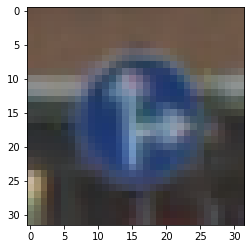

In [16]:
plot.imshow(X_train[900])

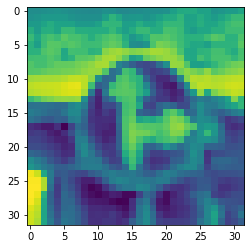

In [17]:
plot.imshow(X_train_norm[900][:,:,0]);

In [18]:
def display_layer(outputs_history, col_size, row_size, layer_index): 
    activation       = outputs_history[layer_index]
    activation_index = 0
    fig, ax          = plot.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].axis('off')
            if activation_index < activation.shape[3]:
                ax[row][col].imshow(activation[0, :, :, activation_index])   # , cmap='gray'             
                activation_index += 1

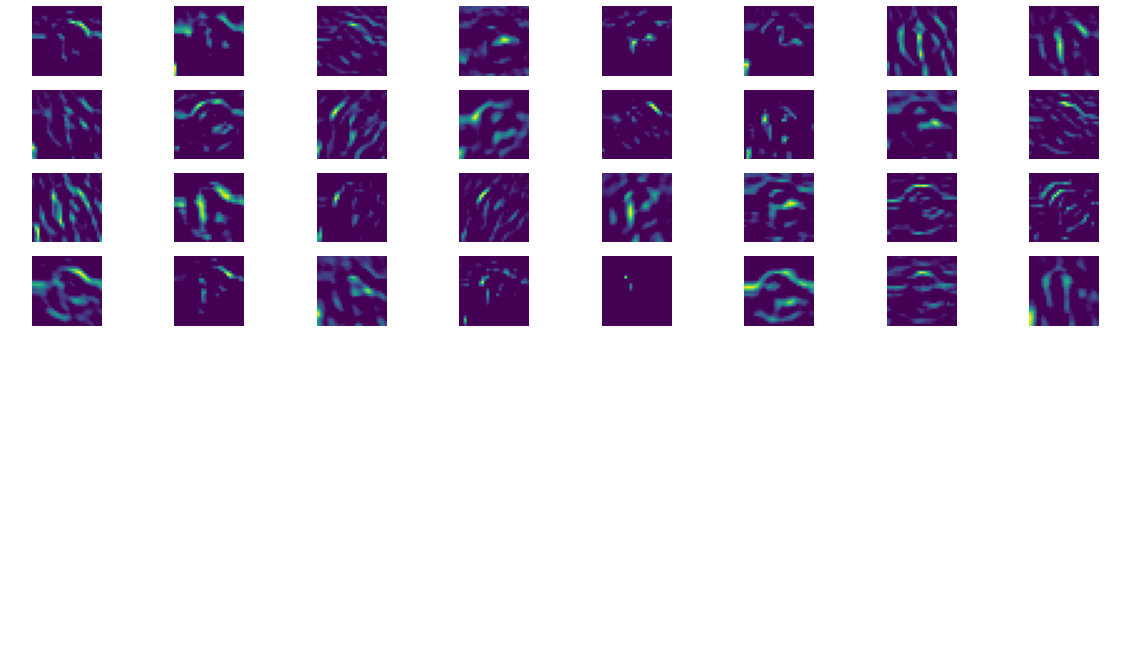

In [19]:
display_layer(outputs_history, 8, 8, 1)

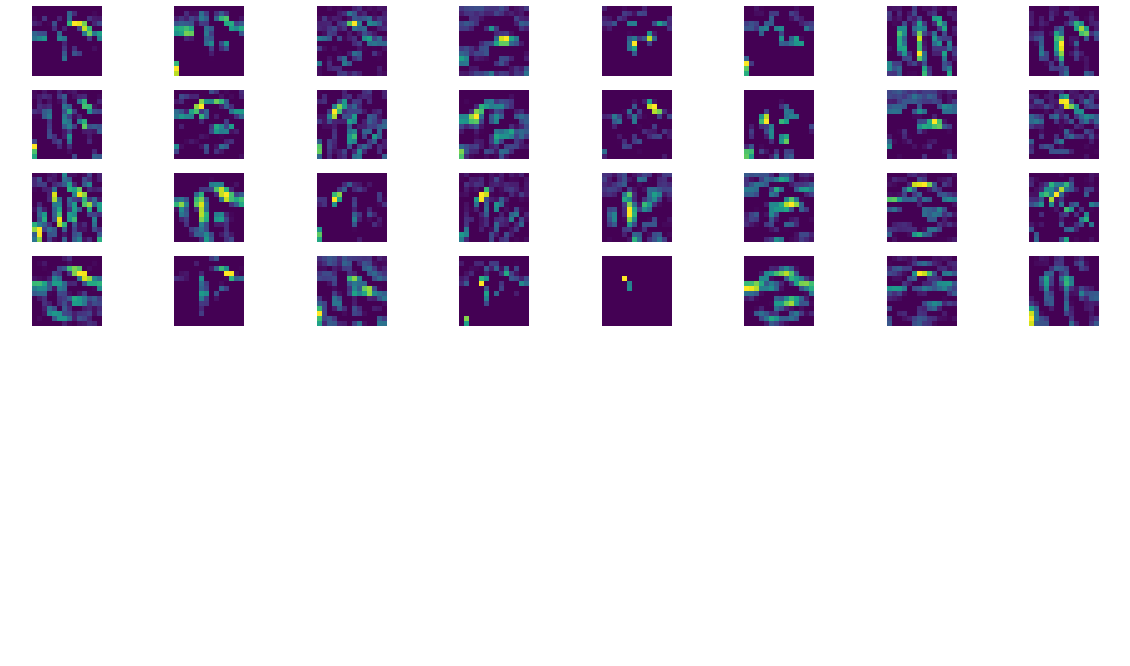

In [20]:
display_layer(outputs_history, 8, 8, 2)

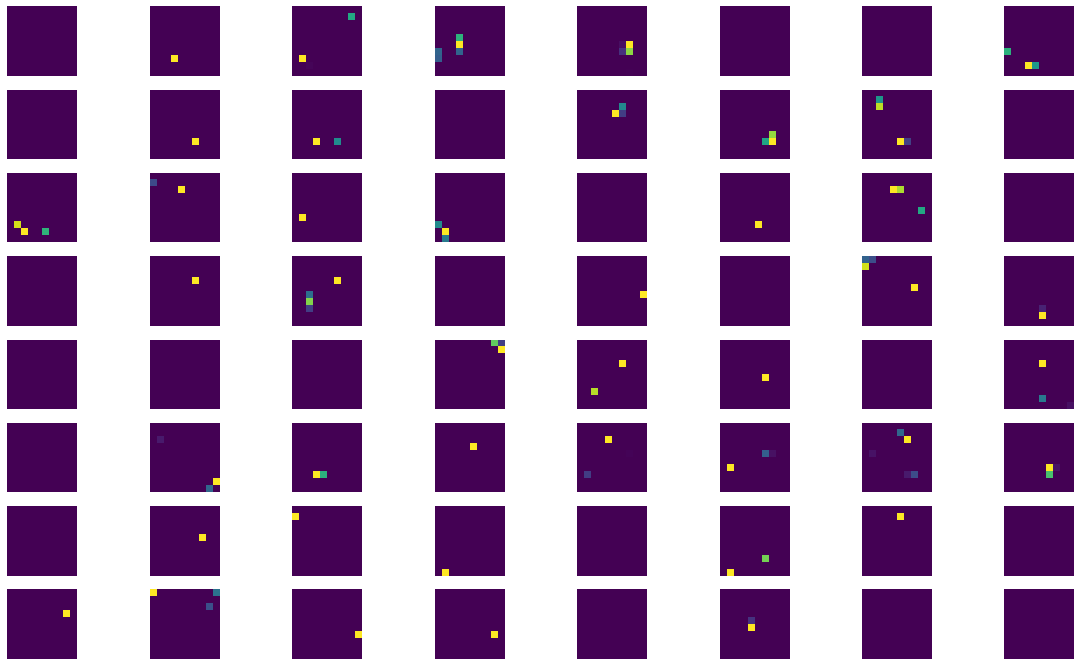

In [21]:
display_layer(outputs_history, 8, 8, 3)

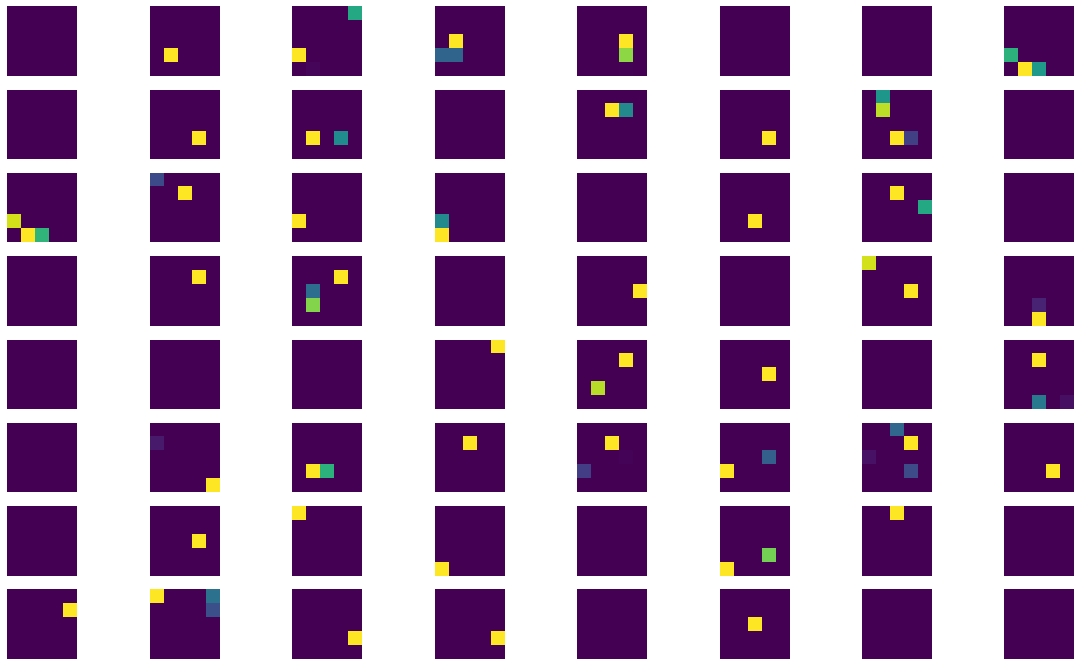

In [22]:
display_layer(outputs_history, 8, 8, 4)